In [ ]:
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from tensorflow.keras.models import save_model
import matplotlib.pyplot as plt

In [ ]:
def augment_image(image, mask):
    augmented_images = []
    augmented_masks = []

    # Original image
    augmented_images.append(image)
    augmented_masks.append(mask)

    # Horizontal flip
    augmented_images.append(np.fliplr(image))
    augmented_masks.append(np.fliplr(mask))

    # Vertical flip
    augmented_images.append(np.flipud(image))
    augmented_masks.append(np.flipud(mask))

    # Rotate 90 degrees
    augmented_images.append(np.rot90(image, k=1))
    augmented_masks.append(np.rot90(mask, k=1))

    # Rotate 180 degrees
    augmented_images.append(np.rot90(image, k=2))
    augmented_masks.append(np.rot90(mask, k=2))

    # Rotate 270 degrees
    augmented_images.append(np.rot90(image, k=3))
    augmented_masks.append(np.rot90(mask, k=3))

    return augmented_images, augmented_masks

In [ ]:
# Enhanced U-Net Architecture
def enhanced_unet_model(input_shape=(48, 48, 1)):
    inputs = Input(input_shape)

    # Contracting Path (Encoder)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)  # Adding dropout to prevent overfitting

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.2)(p4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    p5 = Dropout(0.3)(c5)

    # Expanding Path (Decoder)
    u6 = UpSampling2D((2, 2))(p5)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Concatenate()([c6, c4])  # Skip connection from encoder
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Concatenate()([c7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Concatenate()([c8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Concatenate()([c9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs, outputs)

In [ ]:
# Load the training and mask datasets
X_train = np.load('Xtrain2_b.npy')  # 48x48 images
y_train = np.load('Ytrain2_b.npy')  # Segmentation masks
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

y_train = y_train.astype('float32') / 255.0  # Normalize mask values

# Reshape to include channels (48x48 -> 48x48x1)
X_train = X_train.reshape(-1, 48, 48, 1)
y_train = y_train.reshape(-1, 48, 48, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (547, 2304)
y_train shape: (547, 2304)
X_train shape: (547, 48, 48, 1)
y_train shape: (547, 48, 48, 1)


In [ ]:
# Apply augmentation functions
augmented_X_train = []
augmented_y_train = []

for img, mask in zip(X_train, y_train):
    imgs, masks = augment_image(img, mask)
    augmented_X_train.extend(imgs)
    augmented_y_train.extend(masks)

# Convert lists to numpy arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

# Shuffle the data
idx = np.random.permutation(len(augmented_X_train))
augmented_X_train = augmented_X_train[idx]
augmented_y_train = augmented_y_train[idx]

print("Augmented X_train shape:", augmented_X_train.shape)
print("Augmented y_train shape:", augmented_y_train.shape)

Augmented X_train shape: (3282, 48, 48, 1)
Augmented y_train shape: (3282, 48, 48, 1)


In [ ]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(augmented_X_train, augmented_y_train, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (2625, 48, 48, 1)
y_train shape: (2625, 48, 48, 1)
X_val shape: (657, 48, 48, 1)
y_val shape: (657, 48, 48, 1)


In [ ]:
def custom_generator(image_generator, mask_generator):
    while True:
        X = next(image_generator)  # Change here
        y = next(mask_generator)  # Change here
        yield X, y

In [ ]:
# Step 3: Define the data augmentation
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

# ImageDataGenerator for X (images) and y (masks)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed for both images and masks so the transformations are applied correspondingly
seed = 1
image_generator = image_datagen.flow(X_train, batch_size=16, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=seed)

# Combine the image and mask generators
train_generator = zip(image_generator, mask_generator)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-5)

In [ ]:
# Initialize the U-Net model
unet = enhanced_unet_model(input_shape=(48, 48, 1))
unet.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

# Train the model
history = unet.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 348ms/step - accuracy: 0.6627 - loss: 11.7039 - val_accuracy: 0.6273 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.7045 - loss: 0.5805 - val_accuracy: 0.7369 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.7469 - loss: 0.5324 - val_accuracy: 0.6840 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.7508 - loss: 0.5311 - val_accuracy: 0.7854 - val_loss: 0.4788 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8068 - loss: 0.4503 - val_accuracy: 0.7809 - val_loss: 0.4929 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.8201 - loss: 0.4252 - val_accuracy: 0.8255 - val_loss: 0.4188 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.8281 - 

In [ ]:
# Step 4: Initialize the enhanced U-Net model
enhanced_unet = enhanced_unet_model(input_shape=(48, 48, 1))
enhanced_unet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the model with augmented data
history = enhanced_unet.fit(custom_generator(image_generator, mask_generator), steps_per_epoch=len(X_train) // 16, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.6340 - loss: 1.3892 - val_accuracy: 0.7436 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.7020 - loss: 0.5412 - val_accuracy: 0.7631 - val_loss: 0.5133 - learning_rate: 0.0010
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.7423 - loss: 0.4881 - val_accuracy: 0.8295 - val_loss: 0.4100 - learning_rate: 0.0010
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.7825 - loss: 0.4187 - val_accuracy: 0.8507 - val_loss: 0.3709 - learning_rate: 0.0010
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.7894 - loss: 0.4061 - val_accuracy: 0.8578 - val_loss: 0.3519 - learning_rate: 0.0010
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.7938 - loss: 0.4170 - val_accuracy: 0.8465 - val_loss: 0.3807 - learning_rate: 0.0010
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.7

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
0.814332889155656


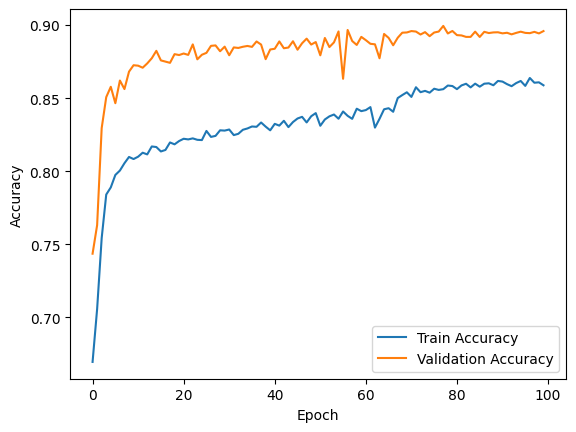

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


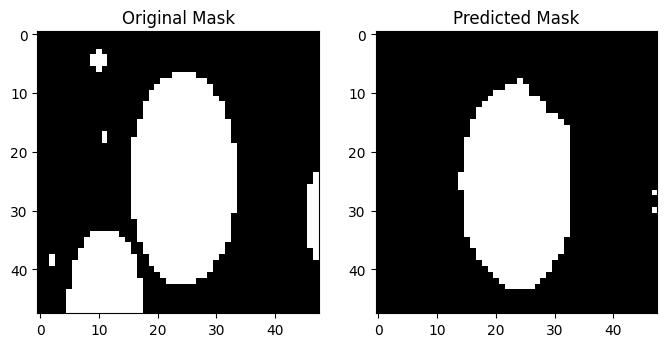

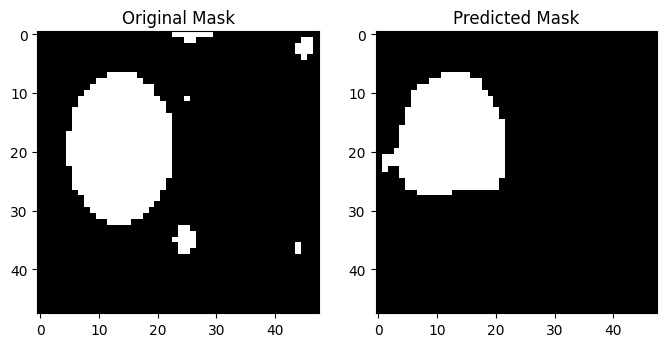

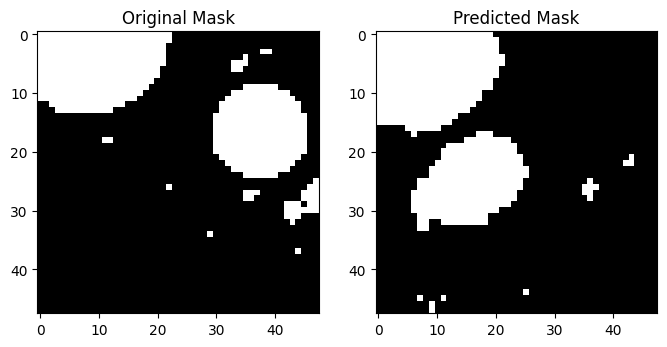

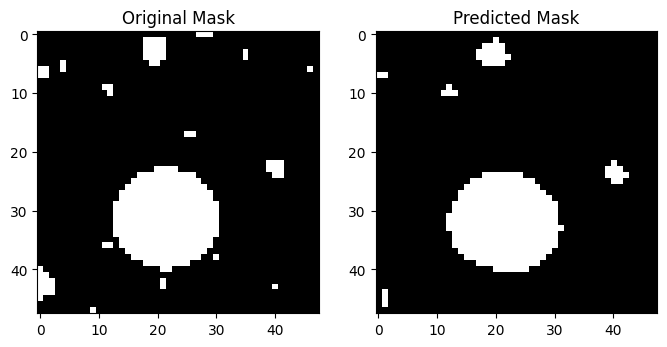

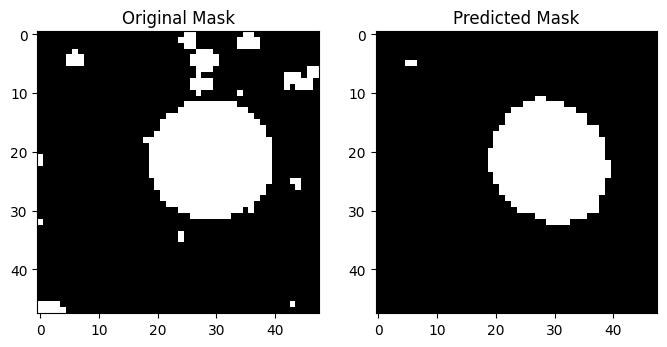

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step


In [ ]:
# calculate Bacc
y_pred = unet.predict(X_val)
y_pred = (y_pred > 0.5).astype(np.uint8)  # Convert probabilities to binary masks

y_pred_flat = y_pred.flatten() # flatten
y_val_flat = y_val.flatten() # flatten

Bacc = balanced_accuracy_score(y_val_flat, y_pred_flat)
print(Bacc)

# Visualize training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Function to visualize predictions
def visualize_predictions(model, X_test, y_val):
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(np.uint8)  # Convert probabilities to binary masks
    for i in range(5):  # Visualize 5 random predictions
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(y_val[i].reshape(48, 48), cmap='gray')
        plt.title('Original Mask')

        plt.subplot(1, 2, 2)
        plt.imshow(predictions[i].reshape(48, 48), cmap='gray')
        plt.title('Predicted Mask')
        plt.show()

# Load test images for visualization (assuming they are in the same shape)
X_test = np.load('Xtest2_b.npy').reshape(-1, 48, 48, 1)
visualize_predictions(unet, X_val, y_val)

pred = unet.predict(X_test)
pred = (pred > 0.5).astype(np.uint8)
np.save('pred_b.npy', pred)

unet.save('unet.keras')


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
0.8645211236070203


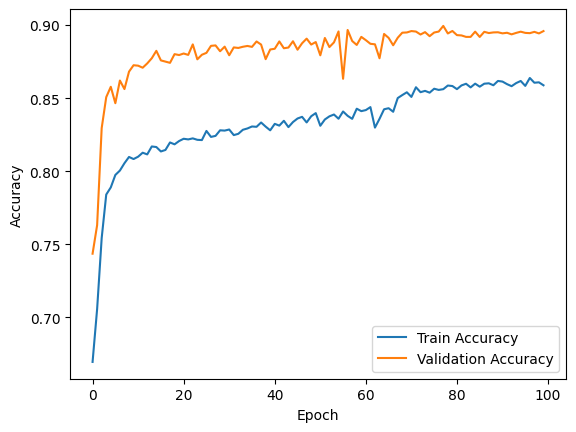

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


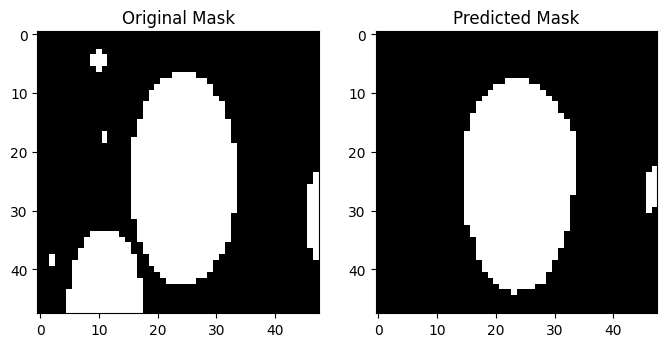

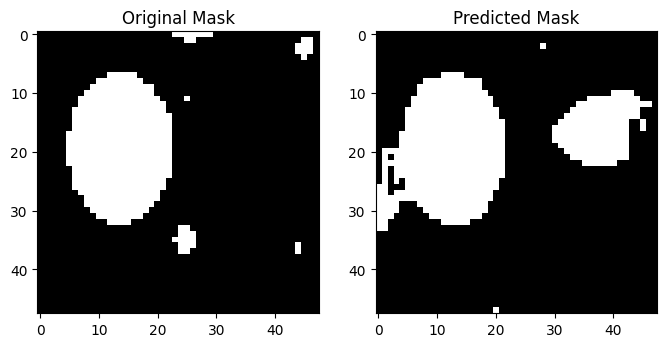

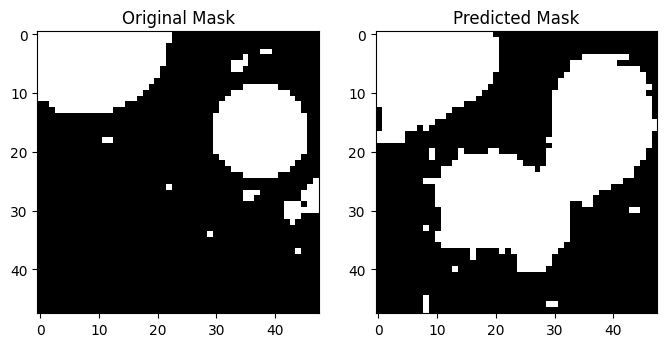

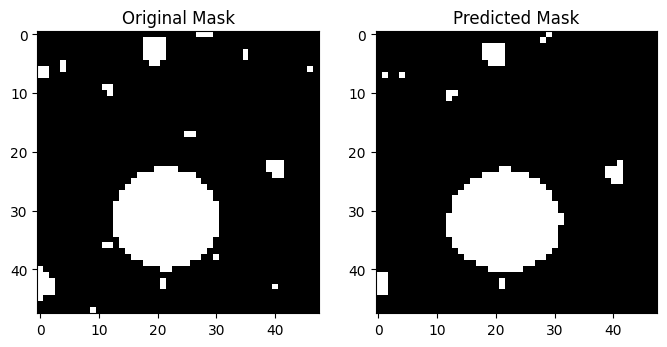

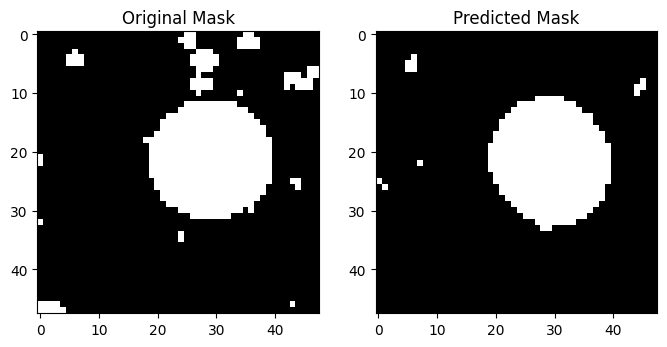

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
(196, 48, 48, 1)
(196, 2304)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# calculate Bacc
y_pred = enhanced_unet.predict(X_val)
y_pred = (y_pred > 0.5).astype(np.uint8)  # Convert probabilities to binary masks

y_pred_flat = y_pred.flatten() # flatten
y_val_flat = y_val.flatten() # flatten

Bacc = balanced_accuracy_score(y_val_flat, y_pred_flat)
print(Bacc)

# Visualize training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Function to visualize predictions
def visualize_predictions(model, X_test, y_val):
    predictions = model.predict(X_test)
    predictions = (predictions > 0.5).astype(np.uint8)  # Convert probabilities to binary masks
    for i in range(5):  # Visualize 5 random predictions
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(y_val[i].reshape(48, 48), cmap='gray')
        plt.title('Original Mask')

        plt.subplot(1, 2, 2)
        plt.imshow(predictions[i].reshape(48, 48), cmap='gray')
        plt.title('Predicted Mask')
        plt.show()

# Load test images for visualization (assuming they are in the same shape)
X_test = np.load('Xtest2_b.npy').reshape(-1, 48, 48, 1)
visualize_predictions(enhanced_unet, X_val, y_val)

pred = enhanced_unet.predict(X_test)
pred = (pred > 0.5).astype(np.uint8)
print(pred.shape)
pred = pred.reshape(-1, 2304)

print(pred.shape)
print(pred)
np.save('pred_b_enhanced.npy', pred)

enhanced_unet.save('enhanced_unet.keras')